## Importing The Libraries

In [42]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import GRU, Dense
from keras.models import Sequential
from keras.models import Model
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import time
import random

## Importing DATASET

In [43]:
Stock_symbol = '^NSEI'
data = pd.read_csv('/content/Data 5 years - Sheet1.csv')
#data = yf.download(Stock_symbol, start='2013-01-01', end = '2022-12-31')

In [44]:
count_nan = data.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
SMA20          0
SMA50          0
EMA20          0
EMA50          0
EMA200         0
UpperBB        0
LowerBB        0
RSI            0
MFI            0
ATR            0
Force_Index    0
MACD           0
MACD_SL        0
ADX            0
OBV            0
OBV_EMA        0
dtype: int64


# List of Features

In [45]:
data = data.loc[:, data.columns != 'Date']

FEATURES=data.columns.tolist()

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(data)
data_filtered = data[FEATURES]
print(data_filtered)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA20', 'SMA50', 'EMA20', 'EMA50', 'EMA200', 'UpperBB', 'LowerBB', 'RSI', 'MFI', 'ATR', 'Force_Index', 'MACD', 'MACD_SL', 'ADX', 'OBV', 'OBV_EMA']
             Open         High          Low        Close    Adj Close  Volume  \
0     10477.54980  10495.20020  10404.65039  10442.20020  10442.20020  153400   
1     10482.65039  10503.59961  10429.54980  10443.20020  10443.20020  167300   
2     10469.40039  10513.00000  10441.45020  10504.79980  10504.79980  174900   
3     10534.25000  10566.09961  10520.09961  10558.84961  10558.84961  180900   
4     10591.70020  10631.20020  10588.54980  10623.59961  10623.59961  169000   
...           ...          ...          ...          ...          ...     ...   
1227  17830.40039  18084.09961  17774.25000  18014.59961  18014.59961  176700   
1228  18089.80078  18149.25000  17967.44922  18132.30078  18132.30078  214300   
1229  18084.75000  18173.09961  18068.34961  18122.500

# Scaling the DATA

In [46]:

nrows = data_filtered.shape[0]
print(nrows)

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
data_filtered.head()

1232


,Open,High,Low,Close,Adj Close,Volume,SMA20,SMA50,EMA20,EMA50,...,LowerBB,RSI,MFI,ATR,Force_Index,MACD,MACD_SL,ADX,OBV,OBV_EMA
0,10477.54980,10495.20020,10404.65039,10442.20020,10442.20020,153400,10338.28257,10321.71500,10391.95908,10295.15271,...,10065.99898,55.795277,47.511587,97.721261,-1.357590e+07,65.926644,13.548731,15.715331,12111500,11957990.74
1,10482.65039,10503.59961,10429.54980,10443.20020,10443.20020,167300,10354.05508,10326.88201,10396.83919,10300.95849,...,10068.06503,55.861800,54.258031,96.160575,1.673000e+05,61.722033,7.475296,16.052246,12278800,11973267.37
2,10469.40039,10513.00000,10441.45020,10504.79980,10504.79980,174900,10373.38257,10332.82400,10407.12115,10308.95227,...,10067.10473,59.868178,61.290050,92.221261,1.077377e+07,62.638366,6.713303,16.225820,12453700,11996145.11
3,10534.25000,10566.09961,10520.09961,10558.84961,10558.84961,180900,10399.12007,10338.09400,10421.57148,10318.75216,...,10063.21136,63.038396,61.771720,85.896275,9.777610e+06,66.954128,8.823252,15.628212,12634600,12026547.73
4,10591.70020,10631.20020,10588.54980,10623.59961,10623.59961,169000,10421.96504,10343.69000,10440.81225,10330.70697,...,10055.41773,66.456883,60.517474,85.124930,1.094275e+07,74.737655,13.285424,14.766009,12803600,12063550.22


# Splitting The DATASET

In [47]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
prediction = "Close"
index_Close = data.columns.get_loc(prediction)

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
X_train, Y_train = partition_dataset(sequence_length, train_data)
X_test, Y_test = partition_dataset(sequence_length, test_data)

psf = [0, 1, 2, 4, 6, 11, 17, 18, 20, 21]
X_train   = X_train[:,:,psf]
X_test   = X_test[:,:,psf]

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(X_train[1][sequence_length-1][index_Close])
print(Y_train[0])

(936, 50, 10) (936,)
(246, 50, 10) (246,)
0.23074832198888628
0.23074832198888628


# Error Rate

In [48]:
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    #print('#')
    #print(xt[:,:,x==1].shape)
    # number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    #print(num_train)

    # Define selected featur
    xtrain = xt[:,:,x == 1]
    #print(xtrain.shape)
    ytrain = yt.reshape(num_train)
    xtest = xv[:,:,x == 1]
    ytest = yv.reshape(num_valid)

    # Training
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape= (xtrain.shape[1],xtrain.shape[2])))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(1, activation='ReLU'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
    model.fit(xtrain, ytrain, epochs = 10, batch_size = 32, verbose = 1)
    # Prediction
    ypred   = model.predict(xtest)
    error   = mean_squared_error(ytest, ypred, squared=False)
    
    return error

# Error Rate & Feature Size

In [49]:
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    #print(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    #print(num_feat)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)
        
    return cost

# Initilization Of Position

In [50]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * np.random.rand()        
    
    return X

# Initilization Of Velocity

In [51]:
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * np.random.rand()  
        
    return V, Vmax, Vmin

# Binary Conversion

In [52]:
def binary_conversion(X, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    
    thres = 0.5
    # For specifying Threshold value usin 1) tanh 2)  function (My Change)
    pos_avg =  np.average(X)
    #thres = (math.exp(pos_avg)-math.exp(-pos_avg))/(math.exp(pos_avg)+math.exp(-pos_avg));
    thres = 1 / (1 + math.exp(-pos_avg));
    print('\nThreshold Value:', thres, "\n")
    
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

# Setting Boundry

In [53]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

# Algorithm

In [54]:
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 2)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    print(dim)
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    #print(X)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t = 0
    
    while t < max_iter:
        print("For Iteration Number:", t+1, "\n")
        
        # Binary conversion
        Xbin = binary_conversion(X, N, dim)
        
        # Fitness
        for i in range(N):
            print("For Population Number", i+1, "\n")
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("\nIteration:", t + 1)
        print("Best (PSO):", curve[0,t], "\n")
        t += 1
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = np.random.rand()
                r2     = np.random.rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data

# Assigning Values

In [55]:
fold = {'xt':X_train, 'yt':Y_train, 'xv':X_test, 'yv':Y_test}

In [56]:
c1  = 2         # cognitive factor
c2  = 2         # social factor 
w   = 0.9       # inertia weight
k     = 5       # k-value in KNN
N     = 10       # number of population
T     = 10       # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# Feature Selection

In [57]:
# perform feature selection
start_time = time.time()
fmdl  = jfs(X_train, Y_train, opts)
print("Run Time --- %s seconds ---" % (time.time() - start_time))
sf    = fmdl['sf']
print(sf)


10
For Iteration Number: 1 


Threshold Value: 0.61336729367661 

For Population Number 1 

Epoch 1/10
30/30 [==============================] - 4s 9ms/step - loss: 0.0147 - mae: 0.0855
Epoch 2/10
30/30 [==============================] - 0s 8ms/step - loss: 0.0019 - mae: 0.0274
Epoch 3/10
30/30 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0199
Epoch 4/10
30/30 [==============================] - 0s 7ms/step - loss: 5.7452e-04 - mae: 0.0155
Epoch 5/10
30/30 [==============================] - 0s 7ms/step - loss: 3.9843e-04 - mae: 0.0138
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 3.6526e-04 - mae: 0.0133
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 3.3791e-04 - mae: 0.0129
Epoch 8/10
30/30 [==============================] - 0s 9ms/step - loss: 3.1660e-04 - mae: 0.0126
Epoch 9/10
30/30 [==============================] - 0s 10ms/step - loss: 3.0761e-04 - mae: 0.0124
Epoch 10/10
8/8 [===========================

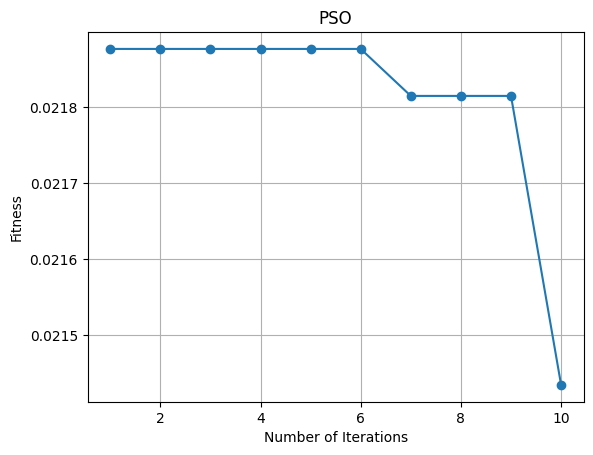

In [58]:
# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [59]:
# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

#Selected Features
print('FEATURE LIST:')
for i in sf:
    print(FEATURES[i], end=', ')
    

Feature Size: 2
FEATURE LIST:
Close, Volume, 

# Making Prediction with Selected Features

In [60]:
# model with selected features
num_train = np.size(X_train, 0)
num_valid = np.size(X_test, 0)
print(X_train.shape)
X_train   = X_train[:,:,sf]
print(X_train.shape)
Y_train   = Y_train.reshape(num_train)  # Solve bug
X_test   = X_test[:,:,sf]
Y_test   = Y_test.reshape(num_valid) 

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
model.add(GRU(64, return_sequences=False))
model.add(Dense(1, activation='ReLU'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
model.fit(X_train, Y_train, epochs = 10, batch_size = 32, verbose = 1)

# accuracy
y_pred    = model.predict(X_test)
RMSE       = mean_squared_error(Y_test, y_pred, squared=False)
print("RMSE:", RMSE)

accuracy = r2_score(Y_test, y_pred)
print('Accuracy:', accuracy)

(936, 50, 10)
(936, 50, 2)
Epoch 1/10
30/30 [==============================] - 4s 8ms/step - loss: 0.0309 - mae: 0.1167
Epoch 2/10
30/30 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0325
Epoch 3/10
30/30 [==============================] - 0s 8ms/step - loss: 0.0013 - mae: 0.0233
Epoch 4/10
30/30 [==============================] - 0s 8ms/step - loss: 9.0760e-04 - mae: 0.0188
Epoch 5/10
30/30 [==============================] - 0s 7ms/step - loss: 6.2751e-04 - mae: 0.0164
Epoch 6/10
30/30 [==============================] - 0s 7ms/step - loss: 4.4851e-04 - mae: 0.0142
Epoch 7/10
30/30 [==============================] - 0s 8ms/step - loss: 3.7270e-04 - mae: 0.0134
Epoch 8/10
30/30 [==============================] - 0s 8ms/step - loss: 3.4178e-04 - mae: 0.0131
Epoch 9/10
30/30 [==============================] - 0s 8ms/step - loss: 3.3287e-04 - mae: 0.0130
Epoch 10/10
8/8 [==============================] - 1s 4ms/step
RMSE: 0.0211393091100632
Accuracy: 0.919682038145

# Graphical Representation

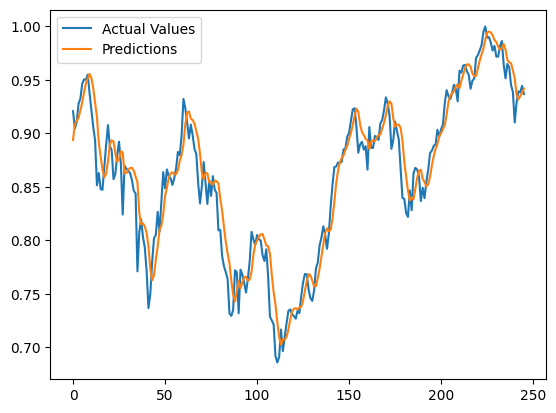

In [61]:
scaler.inverse_transform(np_data)
scaler_pred.inverse_transform(y_pred)

plt.plot(Y_test.reshape(-1, 1), label='Actual Values')
plt.plot(y_pred.reshape(-1, 1), label='Predictions')
plt.legend()
plt.show()